# Q-learning Tic Tac Toe

### To test my RL theory so far, I want to create an undefeatable tic-tac-toe-agent.

In [2]:
""" Imports """

import numpy as np
import random as rnd
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Tic-tac-toe 'physics'

In [3]:
BOARD = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
])

action_space = {
    action: state
    for action, state in enumerate(zip(*np.where(BOARD==0)))
}

action_lookup = {
    state: action
    for action, state in action_space.items()
}

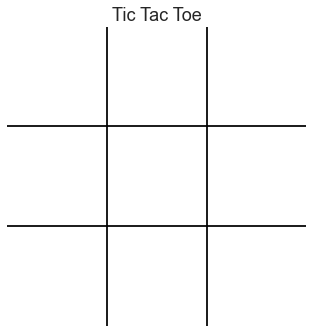

In [4]:
translate = lambda val: {0:"", 1:"O", 2:"X"}[val]

def tic_tac_toe(board: np.ndarray) -> None:
    """ Plot passed board """
    plt.imshow(np.zeros_like(board))
    plt.title("Tic Tac Toe", fontdict={"size":18})
    plt.hlines(.5, -.5, 2.5, colors="k")
    plt.hlines(1.5,-.5, 2.5, colors="k")
    plt.vlines(.5, -.5, 2.5, colors="k")
    plt.vlines(1.5,-.5, 2.5, colors="k")
    
    for (y,x), val in np.ndenumerate(board):
        plt.text(x-.25, y+.2, translate(val), fontdict={"size":64})
        
    plt.gca().set_axis_off()

free_space = lambda board: list(zip(*np.where(board==0)))

tic_tac_toe(BOARD)

# Pre-calculate state space through randomized games

In [5]:
state_space = {tuple(0 for _ in range(9))}

for episode in range(int(1e5)):
    board = np.copy(BOARD)
    
    player = 2
    while len(free_space(board)) > 0:
        player = 1 if player==2 else 2
        state = rnd.choice(free_space(board))
        board[state] = player
        state_space.add(tuple(board.flatten()))

state_space = tuple(sorted(state_space))

print(f"Found {len(state_space)} unique states")

Found 6046 unique states


# Possible actions (random and greedy)

In [6]:
get_state = lambda flattened: state_space.index(flattened)

def policy(Q:np.ndarray, state:tuple, eps=0.5):
    possible_actions = list(map(lambda pos: action_lookup[pos], zip(*np.where(board==0))))
    if 1-eps < rnd.random(): return rnd.choice(possible_actions)
    return possible_actions[np.argmax(Q[state][possible_actions])]

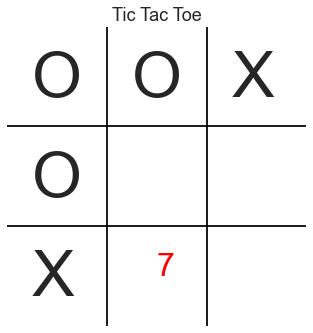

In [101]:
state_action_value = np.random.random((len(state_space), 9))

board = np.array(rnd.choice(state_space)).reshape((3,3))
state = get_state(tuple(board.flatten()))

action = policy(state_action_value, state, 0)

tic_tac_toe(board)
plt.text(*reversed(action_space[action]), action,
         fontdict={"size":32}, c="r");

# Win condition

In [102]:
def win_condition(board:np.ndarray) -> int:
    for idx in range(3):
        if board[0, idx] != 0:
            if all(board[:, idx] == board[0, idx]):
                return board[0, idx]
        if board[idx, 0] != 0:
            if all(board[idx, :] == board[idx, 0]):
                return board[idx, 0]

    if all(board.diagonal() == board[0,0]):
        if board[0,0] != 0:
            return board[0,0]
    if all(np.fliplr(board).diagonal() == board[2,0]):
        if board[2,0] != 0:
            return board[2,0]
        
    return 0

# Random games with outcome

Player 1 wins


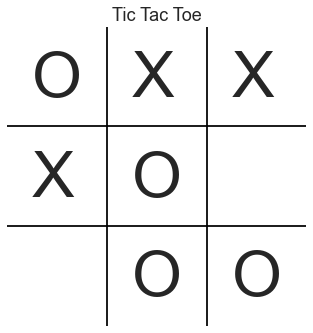

In [103]:
board = np.copy(BOARD)

player = 2
while len(free_space(board)) > 0:
    player = 1 if player==2 else 2

    state = get_state(tuple(board.flatten()))
    action = policy(None, state, 1)
    board[action_space[action]] = player

    victor = win_condition(board)
    if victor != 0:
        print(f"Player {victor} wins")
        break
        
else: print("Draw")
        
tic_tac_toe(board)

# Q-learning control

In [40]:
def q_learning(Q, s, a, r, s_) -> float:
    curr_sa = Q[s][a]
    max_a = max(Q[s_][a_] for a_ in action_space)
    
    return curr_sa + alpha * (r + (gamma*max_a) - curr_sa)

def get_score(board:np.ndarray) -> int: 
    victor = win_condition(board)
    if victor == 1:
        return 1
    elif victor == 2:
        return -1
    else:
        return 0

{'state': 0, 'action': 5, 'reward': 0, 'next state': 21}
{'state': 0, 'action': 2, 'reward': 0, 'next state': 459}
{'state': 0, 'action': 1, 'reward': 0, 'next state': 1157}
{'state': 0, 'action': 0, 'reward': 1, 'next state': 3165}


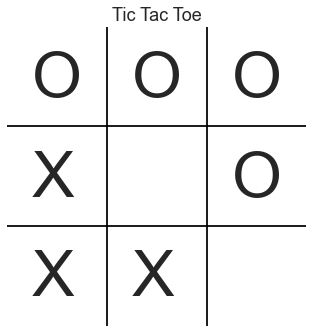

In [41]:
""" Single Game """

alpha = 2e-3
epsilon = 0.5
gamma = 1

state_action_value = np.random.random((len(state_space), 9))

board = np.copy(BOARD)
state = 0

while get_score(board) == 0 and len(free_space(board)) > 0:
    action = policy(state_action_value, state)
    board[action_space[action]] = 1
    if win_condition(board) == 0 and len(free_space(board)) > 0:
        board[action_space[policy(None, get_state(tuple(board.flatten())), 1)]] = 2

    reward = get_score(board)

    next_s = get_state(tuple(board.flatten()))

    state_action_value[state][action] = q_learning(state_action_value,
                                                  state, action, reward, next_s)

    print({"state":state, "action":action, "reward":reward, "next state":next_s})
    
tic_tac_toe(board)

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


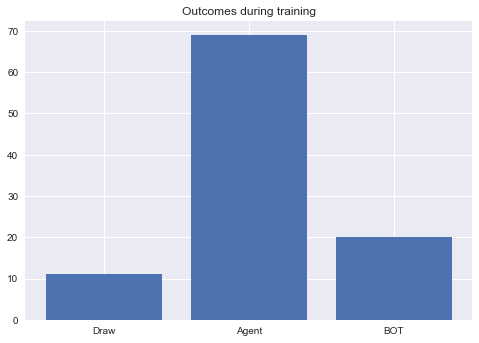

In [71]:
""" Training session"""

outcomes = {0: 0, 1: 0, 2: 0}

alpha = 0.5
epsilon = 0.66
gamma = 1

state_action_value = np.zeros((len(state_space), 9))

num_games = int(1e2)
for episode in range(1, num_games+1):
    board = np.copy(BOARD)
    state = 0

    while win_condition(board) == 0 and len(free_space(board)) > 0:
        action = policy(state_action_value, state, epsilon)
        board[action_space[action]] = 1
        
        if win_condition(board) == 0 and len(free_space(board)) > 0:
            board[action_space[policy(state_action_value, get_state(tuple(board.flatten())), 0)]] = 2

        reward = get_score(board)
        next_s = get_state(tuple(board.flatten()))
        state_action_value[state][action] = q_learning(state_action_value,
                                                       state, action, reward, next_s)
        state = next_s
        
    else: outcomes[win_condition(board)] += 1
        
        
    if episode % (num_games//10) == 0:
        print(f"State-action value optimization is {episode / num_games:.0%} done.")
        
plt.bar(["Draw", "Agent", "BOT"], outcomes.values())
plt.title("Outcomes during training"); plt.show()

### Save values for later use

In [21]:
np.save("tic_tac_toe_1e7.npy", state_action_value)

# Player controlled game loop

In [72]:
from IPython.display import clear_output

def display(board:np.ndarray, show_states=False) -> None:
    """ Clear and display the updated board with possible actions """
    
    clear_output()
    tic_tac_toe(board)
    
    if show_states:
        for action in list(map(lambda pos: action_lookup[pos], zip(*np.where(board==0)))):
            state = reversed(action_space[action])
            plt.text(*state, action)
            
    plt.show()

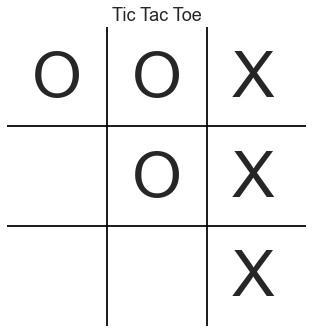

Player 2 wins


In [73]:
board = np.copy(BOARD)
state = 0

while get_score(board) == 0 and len(free_space(board)) > 0:
    action = policy(state_action_value, state, 0)
    board[action_space[action]] = 1
    
    display(board, True)
    
    if win_condition(board) == 0 and len(free_space(board)) > 0:
        while True:
            action = int(input("Make a move: "))
            if action in list(map(lambda pos: action_lookup[pos], zip(*np.where(board==0)))):
                board[action_space[action]] = 2
                break
                
display(board)
print(f"Player {win_condition(board)} wins")

# Adversarial Q-learning control
### Due to the random actions of Player 2, our Agent isn't capable of learning real strategy, rather it exploits easy wins. This should be greatly improved by *adversarial play!* where both agents will learn together

In [74]:
def get_score(player:int, board:np.ndarray) -> int: 
    """ Modified function for 2 players """
    
    victor = win_condition(board)
    if victor == 0:
        return 0
    elif victor == player:
        return 1
    else:
        return -1

State-action value optimization is 10% done.
State-action value optimization is 20% done.
State-action value optimization is 30% done.
State-action value optimization is 40% done.
State-action value optimization is 50% done.
State-action value optimization is 60% done.
State-action value optimization is 70% done.
State-action value optimization is 80% done.
State-action value optimization is 90% done.
State-action value optimization is 100% done.


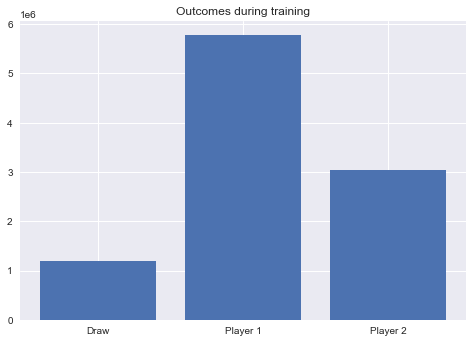

8423 states updated.


In [280]:
""" Adversarial training """

outcomes = {0: 0, 1: 0, 2: 0}

alpha = 0.5
epsilon = 0.66
gamma = 1

player_1_values = np.zeros((len(state_space), 9))
player_2_values = np.zeros((len(state_space), 9))
state_action_dict = {
    1: player_1_values,
    2: player_2_values
}

num_games = int(1e7)
for episode in range(1, num_games+1):
    #print(f"\nEpisode: {episode}")
    board = np.copy(BOARD)
    update = []
    player = 2
    state = 0
    
    while win_condition(board) == 0 and len(free_space(board)) > 0:
        player = 1 if player==2 else 2
        
        action = policy(state_action_dict[player], state, epsilon)
        board[action_space[action]] = player
        next_s = get_state(tuple(board.flatten()))
        reward = get_score(player, board)
        
        if reward > 0: update[3] = -1
        if len(update) != 0:
            update[4] = next_s
            #print({"player":update[0], "state":update[1], "action":update[2], "reward":update[3], "next_s":update[4]})   
            state_action_dict[update[0]][update[1]][update[2]] = q_learning(
                state_action_dict[update[0]], *update[1:]
            )
        
        update = [player, state, action, reward, next_s]
        
        state = next_s
        
    else: 
        #print({"player":update[0], "state":update[1], "action":update[2], "reward":update[3], "next_s":update[4]})
        state_action_dict[update[0]][update[1]][update[2]] = q_learning(
            state_action_dict[update[0]], *update[1:]
        )
        
        result = win_condition(board)
        outcomes[result] += 1
        #print("Draw game." if result==0 else f"Player {win_condition(board)} wins.")
        
    if episode % (num_games//10) == 0:
        print(f"State-action value optimization is {episode / num_games:.0%} done.")
        
plt.bar(["Draw", "Player 1", "Player 2"], outcomes.values())
plt.title("Outcomes during training"); plt.show()

print(len(np.nonzero(player_1_values)[0]), "states updated.")

## One of the first issues here is that state 0 (empty board) is not being updated

#### False, This leads to almost every first action being: an 'O' in position (0,0) because there aren't enough episode played to update the state-action values for that state.

- 1e4 episodes: ~2500 updated states | No updates in state 0
- 1e5 episodes: ~4800 updated states | No updates in state 0
- 1e6 episodes: ~4800 updated states | No updates in state 0

#### The real problem was: Q-learning's next state value being set to board state after own move. 
#### It seems important to set the next state's value after the opponent has made it's move.

- 1e4 episodes: ~5000 updated states | All state 0 values updated
- 1e5 episodes: ~8300 updated states | All state 0 values updated
- 1e6 episodes: ~8400 updated states | All state 0 values updated
- 1e6 episodes:  8423 updated states | All state 0 values updated

#### !!! Huge note-to-self: In turn based games make sure to: pass correct, delayed successor state to Q-learning (opponents change)

In [232]:
""" Debugging Adversarial Q-learning control:
    Checking state-action values for all possible opener moves """

print("State: ", 0)
print(player_1_values[0])
print(player_2_values[0])
print()
    
for idx in range(9):
    board = np.copy(BOARD)
    board[idx//3, idx%3] = 1
    state = get_state(tuple(board.flatten()))
    print("State: ", state)
    print(player_1_values[state])
    print(player_2_values[state])
    print()

State:  0
[0.99999842 0.9982434  0.96691635 0.97121054 0.98660864 0.99948219
 0.94336629 0.9712898  0.99813923]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]

State:  2123
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.54115104 0.56379907 0.57033374 0.63447485 0.71308611
 0.65969937 0.61080416 0.92021732]

State:  750
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.56409477 0.         0.46922262 0.42302815 0.89310021 0.84972424
 0.96158385 0.68655304 0.92357495]

State:  267
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.72220227 0.35881215 0.         0.34604015 0.71660024 0.24743057
 0.71473902 0.48563217 0.51332206]

State:  96
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.76496164 0.80923625 0.89776167 0.         0.97374239 0.58887613
 0.75989131 0.83626952 0.72254812]

State:  35
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.37872771 0.64509218 0.50600366 0.48429375 0.         0.40057764
 0.73331776 0.62333004 0.27713502]

State:  13
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.82319403 0.36884677 0.70213598 0.41147353 0.70690966 0.
 0.95542673 0.71793877 0.76801808]

Stat

In [281]:
np.save("tic_tac_toe_1e7_maker.npy",   player_1_values)
np.save("tic_tac_toe_1e7_breaker.npy", player_2_values)

In [75]:
player_1_values = np.load("tic_tac_toe_1e6_maker.npy")
player_2_values = np.load("tic_tac_toe_1e6_breaker.npy")

# Play testing as player 2 (breaker)

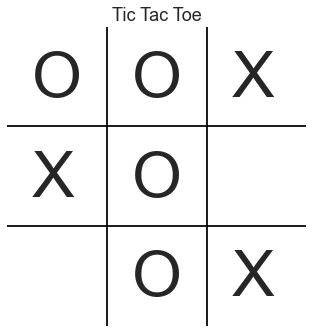

Player 1 wins!


In [107]:
board = np.copy(BOARD)
state = 0

while win_condition(board) == 0 and len(free_space(board)) > 0:
    action = policy(player_1_values, state, 0)
    board[action_space[action]] = 1
    
    display(board, True)
    
    if win_condition(board) == 0 and len(free_space(board)) > 0:
        while True:
            action = int(input("Make a move: "))
            if action in list(map(lambda pos: action_lookup[pos], zip(*np.where(board==0)))):
                board[action_space[action]] = 2
                break
                
    state = get_state(tuple(board.flatten()))
                
display(board)

result = win_condition(board)
print(f"Player {result} wins!" if result!=0 else "Game draw!")

# Play testing as player 1 (maker)

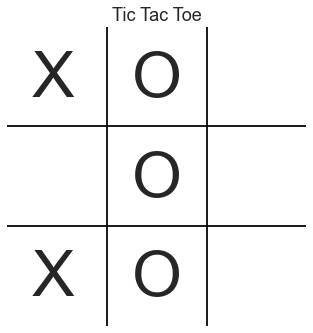

Player 1 wins!


In [109]:
board = np.copy(BOARD)

while win_condition(board) == 0 and len(free_space(board)) > 0:
    display(board, True)
    
    while True:
        action = int(input("Make a move: "))
        if action in list(map(lambda pos: action_lookup[pos], zip(*np.where(board==0)))):
            board[action_space[action]] = 2
            break
            
    board[action_space[action]] = 1
    state = get_state(tuple(board.flatten()))
    
    if win_condition(board) == 0 and len(free_space(board)) > 0:
        action = policy(player_2_values, state, 0)
        board[action_space[action]] = 2
                
display(board)

result = win_condition(board)
print(f"Player {result} wins!" if result!=0 else "Game draw!")

## After only 1e6 episodes both Maker & Breaker agents are 'almost' undefeatable

#### I was only able to beat the Breaker by applying the Maker's strategies because I suck at this game